In [17]:
#Import Packages
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [2]:
train = pd.read_csv("digit_train.csv")
test = pd.read_csv("digit_test.csv")

In [3]:
train.shape

(42000, 785)

In [4]:
#Split data into test/train
X = train.iloc[:,1:]
Y = train.iloc[:,0]

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=10)

### Random Forest Hyperparameter Tuning

In [8]:
#Create model instance 
rf=RandomForestClassifier(random_state=10)

#Parameter Grid for tuning
param_grid = { 
    'n_estimators': [100,200,300,400,500],
    'criterion' :['gini', 'entropy'],
}

In [11]:
#Initiate gridsearch and fit model
from sklearn.model_selection import RandomizedSearchCV
#rfc = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,n_iter=10, n_jobs=-1, verbose =2)
#rfc.fit(X_train, Y_train)

In [ ]:
#rfc.best_params_

In this case we use RandomizedSearch instead of GridSearch due to the length of time it takes for GridSearch to compile. This will result in a less than optimal, but faster solution. The best hyperparameters RandomizedSearch outputs are: n_estimators = 200 and criterion = gini



### Random Forest

In [14]:
#Create new RF model using tuned hyperparameters
rf_final = RandomForestClassifier(random_state=10,criterion='gini',n_estimators=200)
rf_final.fit(X_train, Y_train)

#Predictions
rf_pred_train = rf_final.predict(X_train)
rf_pred_val = rf_final.predict(X_val)

In [19]:
rf_score = cross_val_score(rf_final, X_train, Y_train, cv=5).mean()
print("Accuracy Score of Random Forest (Train): ",rf_score)

Accuracy Score of Random Forest:  0.9628869047619049


In [20]:
rf_score_val = cross_val_score(rf_final, X_val, Y_val, cv=5).mean()
print("Accuracy Score of Random Forest (Validation): ",rf_score_val)

Accuracy Score of Random Forest (Validation):  0.9433333333333334


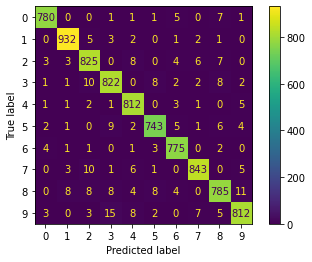

In [22]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_val,rf_pred_val)
matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix.plot()
plt.show()

The random forest model produces very good results for digit label classification. The accuracy score is high (>.90) for both train and test sets, and the confusion matrix shows high values along the diagonal. This confirms that most digits were labeled correctly. It appears that the model had a harder time identifying higher digits (7,8,9) than lower ones (0,1,4). 

### Random Forest Using PCA

In [23]:
from sklearn.decomposition import PCA
principal_components = PCA(n_components=0.85, svd_solver='full')

In [31]:
#Random Forest with PCA (Training)
principal_components.fit(X_train,Y_train)
X_pca = principal_components.transform(X_train)
rf2 = RandomForestClassifier(random_state=10,criterion='gini',n_estimators=200)
rf2.fit(X_pca, Y_train)
rf2_pred_train = rf2.predict(X_pca)
rf2_score = cross_val_score(rf2, X_pca, Y_train, cv=5).mean()
print("Accuracy Score of PCA Random Forest (Train): ",rf2_score)

Accuracy Score of Random Forest (Train):  0.9466964285714285


In [34]:
#Random Forest with PCA (Validation)
principal_components.fit(X_val,Y_val)
X_pca_val = principal_components.transform(X_val)
rf2_val = RandomForestClassifier(random_state=10,criterion='gini',n_estimators=200)
rf2_val.fit(X_pca_val, Y_val)
rf2_pred_val = rf2_val.predict(X_pca_val)
rf2_score_val = cross_val_score(rf2_val, X_pca_val, Y_val, cv=5).mean()
print("Accuracy Score of PCA Random Forest (Validation): ",rf2_score_val)

Accuracy Score of Random Forest (Validation):  0.928095238095238


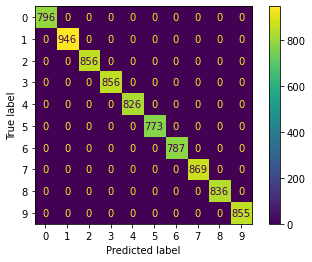

In [35]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_val,rf2_pred_val)
matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix.plot()
plt.show()

We actually see slightly lower accuracy scores for PCA+RF when compared to just RF for training and validation sets. Despite this, the confusion matrix seems to be showing a 100% prediction rate? 

Given the higher metrics for the RF model, we will use that for final predictions. 

In [45]:
#Predictions for Test Data
rf_test = rf_final.predict(test)
np.savetxt('results.csv', 
           np.c_[range(1,len(test)+1),rf_test], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

## Image Classification using Clustering

In [46]:
X = train.iloc[:,1:]
y = train.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [47]:
print('Training Data: {}'.format(X_train.shape))
print('Training Labels: {}'.format(y_train.shape))
print('Testing Data: {}'.format(X_test.shape))
print('Testing Labels: {}'.format(y_test.shape))

Training Data: (33600, 784)
Training Labels: (33600,)
Testing Data: (8400, 784)
Testing Labels: (8400,)


In [48]:
# convert each image to 1 dimensional array
X = X_train.values.reshape(len(X_train),-1)
Y = y_train
# normalize the data to 0 - 1
X = X.astype(float) / 255.
print(X.shape)
print(X[0].shape)

(33600, 784)
(784,)


In [50]:
#K-Means Cluster
from sklearn.cluster import MiniBatchKMeans
n_digits = len(np.unique(y_test))
print(n_digits)
# Initialize KMeans model
kmeans = MiniBatchKMeans(n_clusters = n_digits, batch_size = 2048)
# Fit the model to the training data
kmeans.fit(X)

10


MiniBatchKMeans(batch_size=2048, n_clusters=10)

In [60]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  



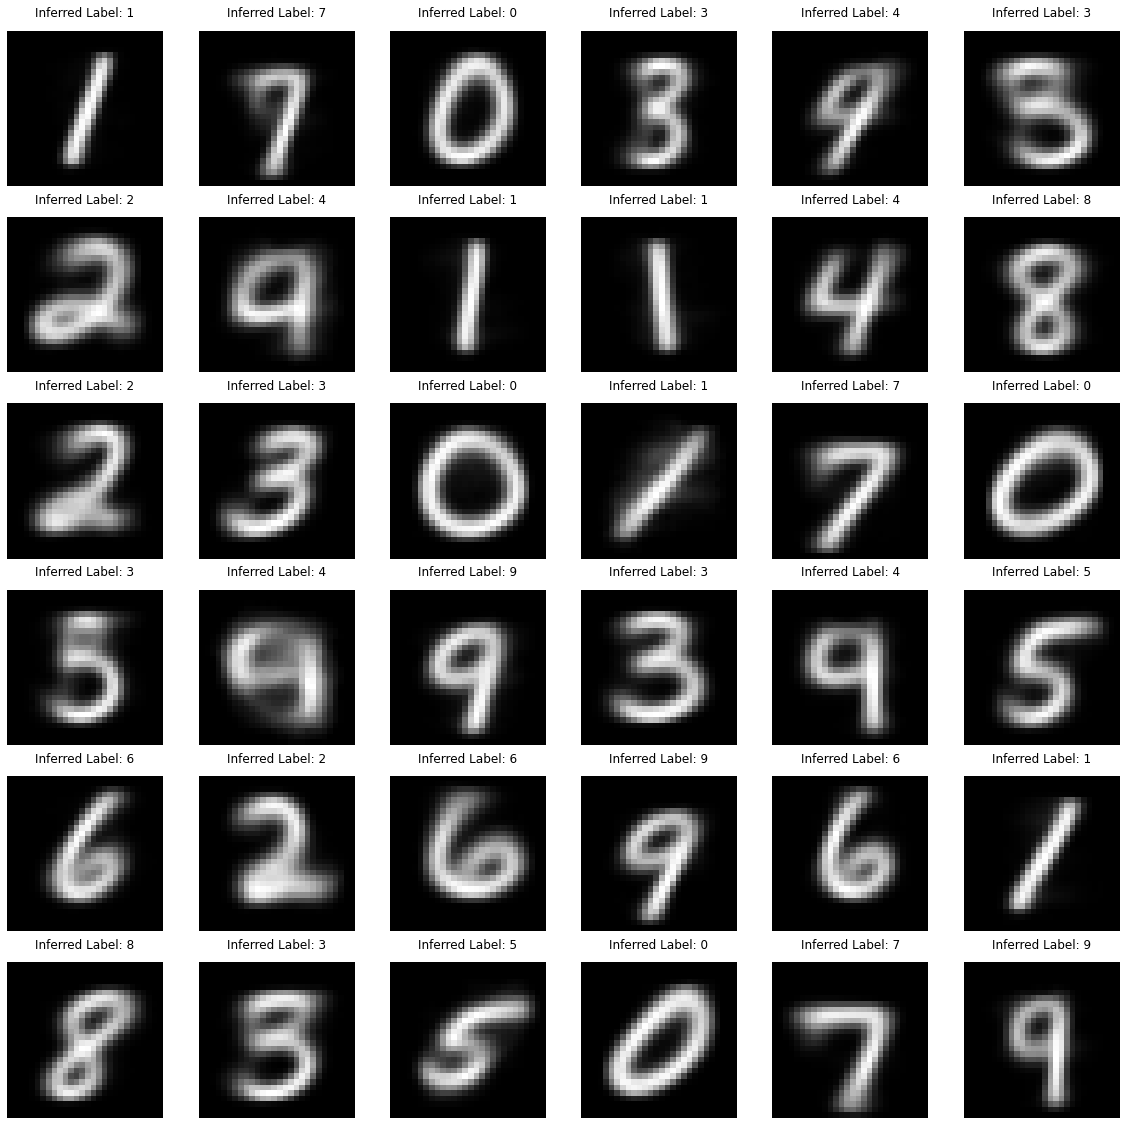

In [61]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 36, batch_size=2048)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 28, 28)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure

We see from this output of 36 sample digits that the classification using cluster performs fairly well; it is able to correctly identify most digits. It struggles a bit distinguishing between 4's and 9's, probably due to their overlap in similar pixel values.  